In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

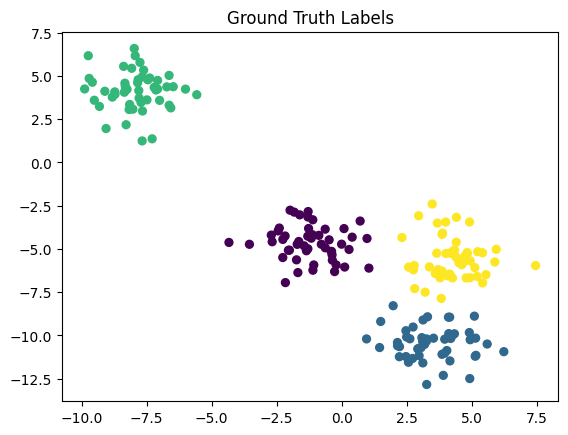

In [92]:
N_SAMPLES = 200
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

In [107]:
def psi(x):
    if x <= 1e-6:
        return -np.euler_gamma - 1./x
    result = 0
    while x < 6:
        result -= 1./x
        x += 1
    r = 1./x
    result += np.log(x) - .5*r
    r = r*r
    result -= r*((1./12.) - r*((1./120.) - r*(1./252.)))
    return result

def dirichlet_expectation_2d(x):
    n_docs, n_words = x.shape
    d_exp = np.empty_like(x)
    for i in range(n_docs):
        row_total = 0
        for j in range(n_words):
            row_total += x[i, j]
        psi_row_total = psi(row_total)
        for j in range(n_words):
            d_exp[i, j] = psi(x[i, j]) - psi_row_total
    return d_exp

def dirichlet_expectation_1d(doc_topic, doc_topic_prior, out):
    size = doc_topic.shape[0]
    total = 0.
    for i in range(size):
        dt = doc_topic[i] + doc_topic_prior
        doc_topic[i] = dt
        total += dt
    psi_total = psi(total)
    for i in range(size):
        out[i] = np.exp(psi(doc_topic[i]) - psi_total)

In [108]:
init_gamma = 100.
init_var = 1./init_gamma
components = np.random.gamma(init_gamma, init_var, (N_TOPICS, N_FEATURES))
exp_dirichlet_component_ = np.exp(dirichlet_expectation_2d(components))

In [120]:
n_docs, n_words = X.shape
doc_topic_prior = 1./N_TOPICS
doc_topic_dist = np.ones((n_docs, N_TOPICS), dtype=X.dtype)
exp_doc_topic = np.exp(dirichlet_expectation_2d(doc_topic_dist))
suff_stats = np.zeros(exp_dirichlet_component_.shape, dtype=X.dtype)
eps = np.finfo(X.dtype).eps
for idx_d in range(n_docs):
    ids = np.nonzero(X[idx_d, :])[0]
    counts = X[idx_d, ids]
    doc_topic_d = doc_topic_dist[idx_d, :]
    exp_doc_topic_d = exp_doc_topic[idx_d, :].copy()
    exp_topic_word_d = exp_dirichlet_component_[:, ids]
    for _ in range(100):
        last_d = doc_topic_d
        norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + eps
        doc_topic_d = exp_doc_topic_d*np.dot(counts/norm_phi, exp_topic_word_d.T)
        dirichlet_expectation_1d(doc_topic_d, doc_topic_prior, exp_doc_topic_d)
    doc_topic_dist[idx_d, :] = doc_topic_d
    norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + eps
    suff_stats[:, ids] += np.outer(exp_doc_topic_d, counts/norm_phi)
suff_stats *= exp_dirichlet_component_

In [111]:
doc_topic_dist.shape

(200, 4)

In [122]:
components.shape

(4, 100)

100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]

Score: 0.815


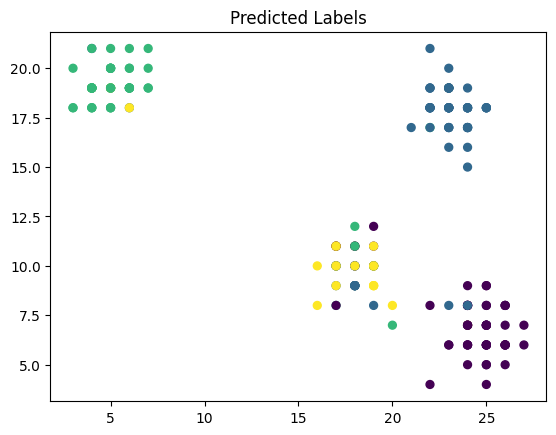

In [75]:
N_STEPS = 1000

model = GibbsLDA(N_TOPICS).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

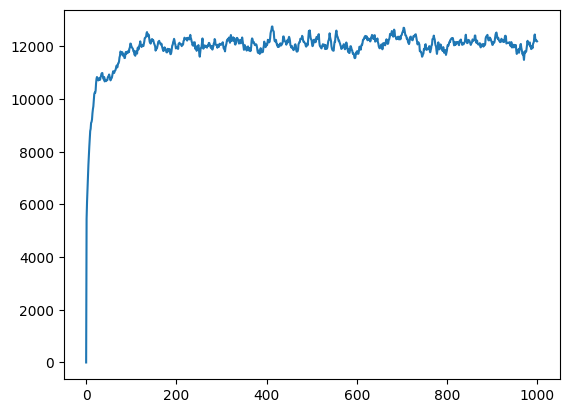

In [76]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s]

Score: 0.805


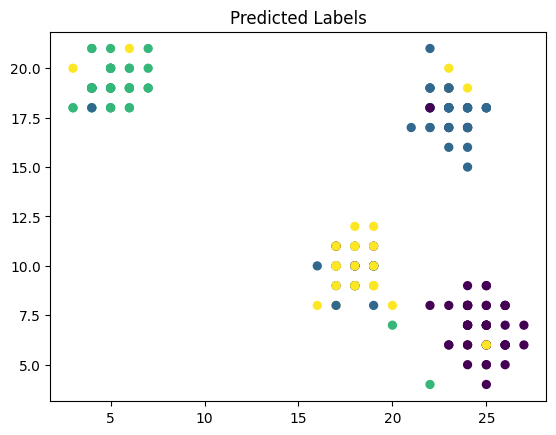

In [77]:
N_STEPS = 1000

model = CollapsedGibbsLDA(N_TOPICS).fit(torch.tensor(X), N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

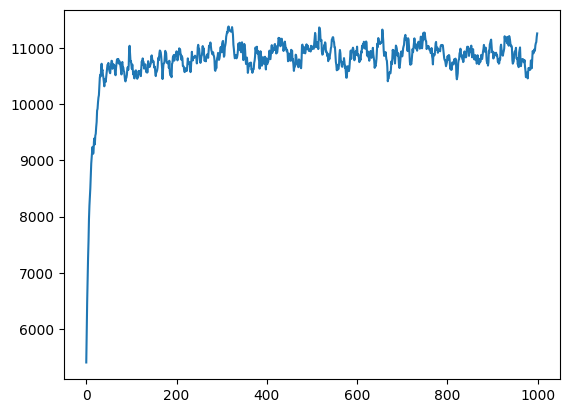

In [78]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s]


Score: 0.84


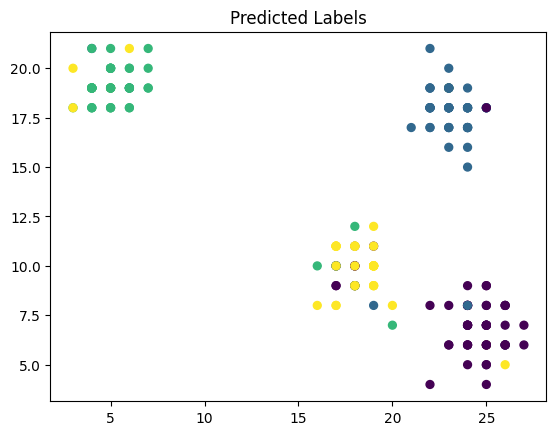

In [79]:
N_STEPS = 1000

pyro.clear_param_store()
Y = torch.tensor(X).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Y, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Y))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

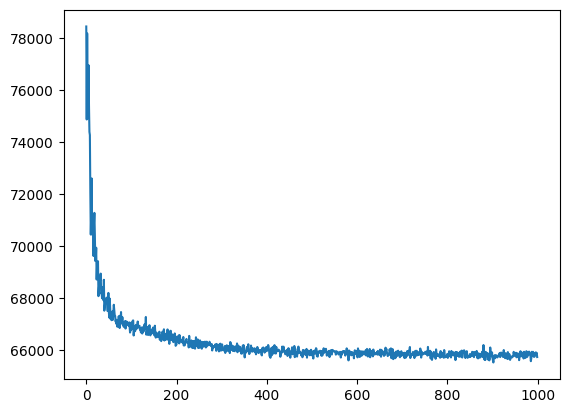

In [80]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);